# 导入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')
DATA_PATH = './data/breastCancer'
PIC_PATH = './pics/breastCancer'
RANDOM_SEED = 42

In [2]:
def parse_dbc(file_path):
    nodes = {}
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Parse nodes and their types
        for line in lines:
            line = line.strip()
            if line.startswith('node'):
                parts = line.split()
                node_name = parts[1]
                node_type = parts[2].strip('()')
                nodes[node_name] = node_type
            elif line.startswith('['):
                line = line.strip('[]').strip().split(', ')
                data.append(line)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=nodes.keys())
    df.replace('?', np.nan, inplace=True)
    
    # Convert data types
    for column, dtype in nodes.items():
        if dtype == 'continuous':
            df[column] = df[column].astype(float)
        elif dtype == 'finite-states':
            df[column] = df[column].astype(object)
    
    return df

df = parse_dbc(os.path.join(DATA_PATH, 'breastCancer_Total.dbc'))
df_train = parse_dbc(os.path.join(DATA_PATH, 'breastCancer_Train.dbc'))
df_test = parse_dbc(os.path.join(DATA_PATH, 'breastCancer_Test.dbc'))
df.head()

,SampleType,Contig45645_RC,Contig44916_RC,D25272,J00129,Contig29982_RC,Contig26811,D25274,Contig36292,Contig42854,...,NM_000895,NM_000898,NM_000899,Contig20164_RC,Contig8985_RC,Contig36062_RC,Contig35333_RC,Contig62037_RC,AF067420,Contig15167_RC
0,relapse,-0.299,0.093,-0.215,-0.566,-0.596,-0.195,0.039,-0.409,-0.352,...,-0.053,-0.960,-0.211,0.155,-0.095,-0.025,-0.037,0.215,0.307,0.321
1,relapse,-0.081,0.009,-0.091,-0.518,-0.502,-0.149,0.098,-0.090,0.138,...,-0.180,-0.531,-0.020,0.014,-0.123,0.148,0.024,-0.070,-0.209,0.105
2,relapse,-0.125,0.070,-0.006,-0.575,-0.585,-0.183,0.102,0.023,-0.350,...,0.180,-0.883,-0.159,0.022,0.006,-0.086,0.019,0.026,-0.822,0.199
3,relapse,-0.270,0.123,0.056,-0.499,-0.402,-0.099,-0.145,-0.103,0.181,...,-0.349,-0.044,-0.096,0.018,0.000,0.076,0.057,-0.016,-0.360,-0.038
4,relapse,-0.141,0.025,-0.031,-0.465,-0.533,-0.065,0.101,-0.008,-0.019,...,0.132,0.280,-0.088,0.043,0.207,-0.124,-0.041,-0.077,-0.432,-0.015


In [115]:
df.isna().sum().sum(), df_train.isna().sum().sum(), df_test.isna().sum().sum()

(42026, 36458, 5568)

In [44]:
df.shape, df_train.shape, df_test.shape

((97, 24482), (78, 24482), (19, 24482))

In [37]:
object_columns = df.select_dtypes(include=['object']).columns
float_columns = df.select_dtypes(include=['float']).columns
object_columns, len(float_columns)

(Index(['SampleType'], dtype='object'), 24481)

In [45]:
df['SampleType'].value_counts(), df_train['SampleType'].value_counts(), df_test['SampleType'].value_counts()

(SampleType
 non-relapse    51
 relapse        46
 Name: count, dtype: int64,
 SampleType
 non-relapse    44
 relapse        34
 Name: count, dtype: int64,
 SampleType
 relapse        12
 non-relapse     7
 Name: count, dtype: int64)

In [49]:
df['SampleType'].isna().sum()

0

In [62]:
df_test['SampleType'].value_counts().sort_index()

SampleType
non-relapse     7
relapse        12
Name: count, dtype: int64

# 数据预处理

In [116]:
df.columns[df.isna().all()]

Index(['Contig51964_RC', 'Contig33383_RC', 'AB033070', 'NM_003042',
       'NM_002390', 'NM_000967', 'NM_000973', 'NM_000998', 'Contig23761_RC',
       'Contig6041_RC',
       ...
       'Contig54076_RC', 'Contig9540_RC', 'NM_000730', 'NM_001478',
       'NM_018898', 'AF073931', 'Contig19700_RC', 'NM_001509', 'NM_000827',
       'Contig30109_RC'],
      dtype='object', length=293)

In [118]:
df_test.columns[df_test.isna().all()]

Index(['Contig51964_RC', 'Contig33383_RC', 'AB033070', 'NM_003042',
       'NM_002390', 'NM_000967', 'NM_000973', 'NM_000998', 'Contig23761_RC',
       'Contig6041_RC',
       ...
       'Contig54076_RC', 'Contig9540_RC', 'NM_000730', 'NM_001478',
       'NM_018898', 'AF073931', 'Contig19700_RC', 'NM_001509', 'NM_000827',
       'Contig30109_RC'],
      dtype='object', length=293)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

def preprocess(train_data, test_data):
    na_col = train_data.columns[train_data.isna().all()]
    train_data.drop(na_col, axis=1, inplace=True)
    test_data.drop(na_col, axis=1, inplace=True)
    y_train = train_data['SampleType'].map({'relapse': 1, 'non-relapse': 0})
    y_test = test_data['SampleType'].map({'relapse': 1, 'non-relapse': 0})
    X_train = train_data.drop(columns=['SampleType'])
    X_test = test_data.drop(columns=['SampleType'])
    pp = Pipeline([
        ('selector', VarianceThreshold(threshold=0)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.99))
    ])
    X_train = pp.fit_transform(X_train)
    X_test = pp.transform(X_test)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(df_train, df_test)

X_train.shape, X_test.shape

((78, 74), (19, 74))

# EDA

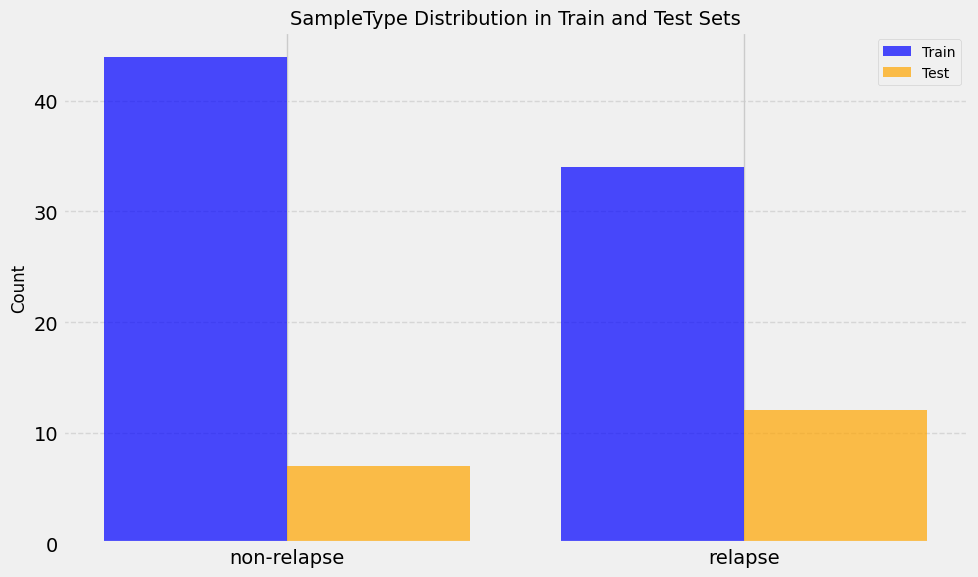

<Figure size 640x480 with 0 Axes>

In [22]:
# 计算训练集和测试集中 SampleType 的分布
train_counts = df_train['SampleType'].value_counts().sort_index()
test_counts = df_test['SampleType'].value_counts().sort_index()

# 设置柱状图的宽度
bar_width = 0.4
x = np.arange(len(train_counts))

# 创建图形
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制训练集和测试集的柱状图
ax.bar(x - bar_width / 2, train_counts, bar_width, label='Train', color='blue', alpha=0.7)
ax.bar(x + bar_width / 2, test_counts, bar_width, label='Test', color='orange', alpha=0.7)

# 设置 x 轴的刻度和标签
ax.set_xticks(x)
ax.set_xticklabels(['non-relapse', 'relapse'], fontsize=14)

# 设置标题和标签
ax.set_title('SampleType Distribution in Train and Test Sets', fontsize=14)
# ax.set_xlabel('SampleType', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# 添加图例
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(PIC_PATH, 'EDA/SampleType Distribution in Train and Test Sets.jpg'))

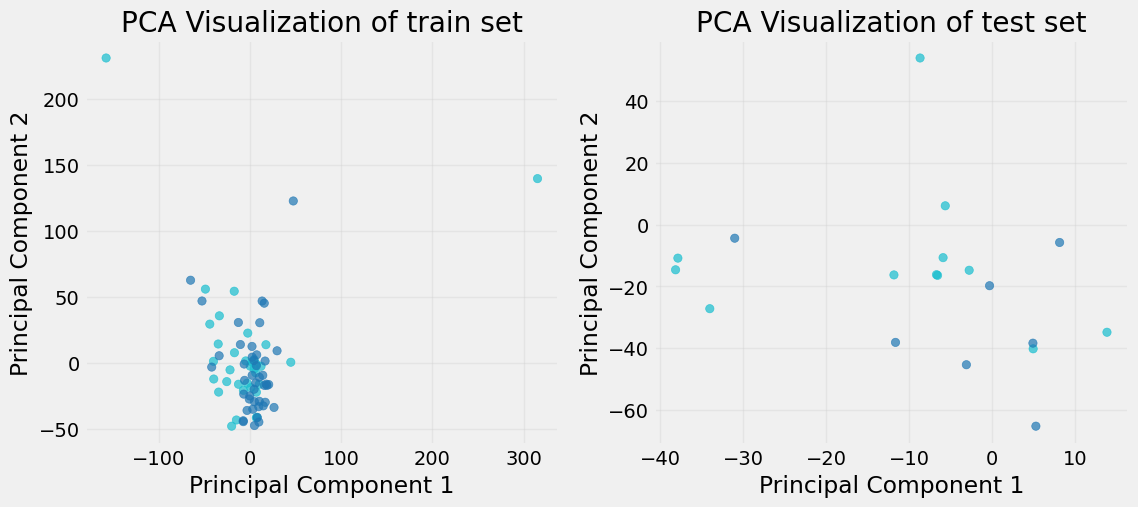

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# 训练集
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', alpha=0.7)
axes[0].set_title("PCA Visualization of train set")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].grid(alpha=0.3)

# 测试集
# data_pca = pca.fit_transform(X_test)
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='tab10', alpha=0.7)
axes[1].set_title("PCA Visualization of test set")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].grid(alpha=0.3)
plt.show()

# XGBoost

accuracy: 63.16%
precision: 69.23%
recall: 75.00%
f1: 72.00%
auc: 58.93%


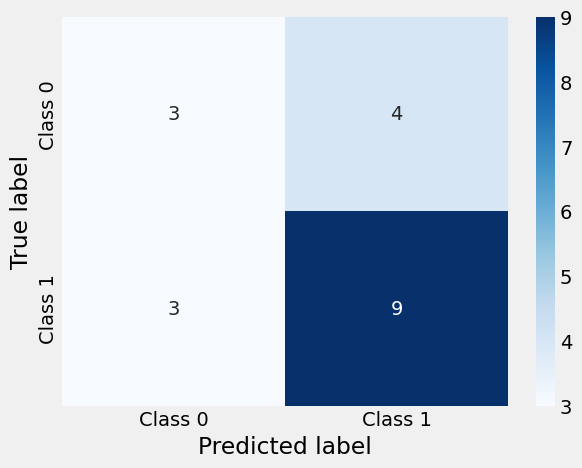

In [6]:
import xgboost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

xgb = xgboost.XGBClassifier(random_state=RANDOM_SEED)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")
print(f"auc: {auc*100:.2f}%")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(os.path.join(PIC_PATH, 'result', 'xgb conf_mat.jpg'))


# RandomForest

## 调库

oob score: 57.69%
accuracy: 57.89%
precision: 83.33%
recall: 41.67%
f1: 55.56%
auc: 63.69%


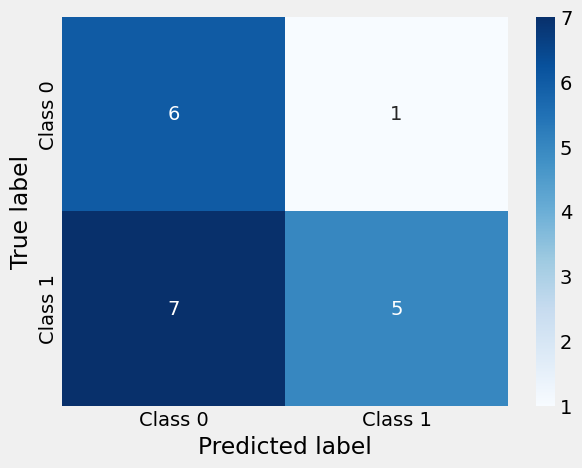

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

random_state = 42
rf_sklearn = RandomForestClassifier(n_estimators=100, 
                            max_depth=None, 
                            random_state=random_state, 
                            max_features='sqrt',
                            oob_score=True)

rf_sklearn.fit(X_train,y_train)
y_pred = rf_sklearn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'oob score: {rf_sklearn.oob_score_*100:.2f}%')
print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")
print(f"auc: {auc*100:.2f}%")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(os.path.join(PIC_PATH, 'result', 'randomForest_skleran conf_mat.jpg'))

## 自实现

accuracy: 57.89%
precision: 75.00%
recall: 50.00%
f1: 60.00%
auc: 69.05%


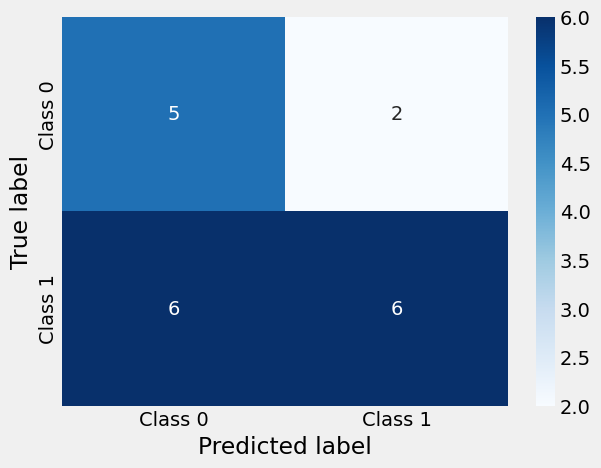

In [5]:
from RandomForest import RandomForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

random_state = 42
rf_custom = RandomForest(n_estimators=100, 
                            max_depth=None, 
                            min_samples_split=2, 
                            mode="classification", 
                            random_state=random_state, 
                        )

rf_custom.fit(X_train,y_train)
y_pred = rf_custom.predict(X_test)
y_prob = rf_custom.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_prob)
cm = confusion_matrix(y_test, y_pred)
# print(f'oob score: {rf_custom.oob_score_*100:.2f}%')
print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")
print(f"auc: {auc*100:.2f}%")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(os.path.join(PIC_PATH, 'result', 'randomForest_custom conf_mat.jpg'))